In [1]:
import glob
import re
import json 
import itertools
import functools
import pickle

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm

from scipy import stats

mpl.rc('font', family='Arial', size=12)

/Users/cimprich/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
mats = glob.glob('../../genome_correlations/tss_plots/*.temp')

In [3]:
sample_extractor = re.compile('/([^/]+)\.([mp]).temp')

In [4]:
filename_correspondence = {f: sample_extractor.findall(f)[0] 
                           for f in mats 
                           if any(i in f for i in ('dmso', 'drb', 'gl3')) and '_1' not in f}

In [5]:
filename_correspondence

{'../../genome_correlations/tss_plots/dmso_2.m.temp': ('dmso_2', 'm'),
 '../../genome_correlations/tss_plots/dmso_2.p.temp': ('dmso_2', 'p'),
 '../../genome_correlations/tss_plots/dmso_3.m.temp': ('dmso_3', 'm'),
 '../../genome_correlations/tss_plots/dmso_3.p.temp': ('dmso_3', 'p'),
 '../../genome_correlations/tss_plots/dmso_in.m.temp': ('dmso_in', 'm'),
 '../../genome_correlations/tss_plots/dmso_in.p.temp': ('dmso_in', 'p'),
 '../../genome_correlations/tss_plots/drb_2.m.temp': ('drb_2', 'm'),
 '../../genome_correlations/tss_plots/drb_2.p.temp': ('drb_2', 'p'),
 '../../genome_correlations/tss_plots/drb_3.m.temp': ('drb_3', 'm'),
 '../../genome_correlations/tss_plots/drb_3.p.temp': ('drb_3', 'p'),
 '../../genome_correlations/tss_plots/drb_in.m.temp': ('drb_in', 'm'),
 '../../genome_correlations/tss_plots/drb_in.p.temp': ('drb_in', 'p'),
 '../../genome_correlations/tss_plots/drb_rh.m.temp': ('drb_rh', 'm'),
 '../../genome_correlations/tss_plots/drb_rh.p.temp': ('drb_rh', 'p'),
 '../../ge

In [6]:
def ucsc_index(df):
    return df.chr.str.cat(df.start.astype(str).str.cat(df.end.astype(str), sep='-'), sep=':')

def read_matrix_file(f):
    temp = pd.read_csv(f, compression='gzip', comment='@', sep='\t', header=None)
    # Generate a UCSC style description of the peak coordinates
    ucsc_idx = (temp.iloc[:, 0].str.cat(
                    temp.iloc[:, 1].astype(str).str.cat(
                        temp.iloc[:, 2].astype(str),
                    sep= '-'), 
                sep=':'))
    # Drop the first 6 columns, which here act as a descriptor
    return temp.set_index(ucsc_idx).drop(range(6), axis=1).fillna(0)

In [7]:
gc_skew = read_matrix_file('../../genome_correlations/tss_plots/nuc_content/gc_skew.temp')

In [8]:
tss_data = {}
for filename, samplename in filename_correspondence.items():
    print(samplename)
    tss_data[samplename] = read_matrix_file(filename)

('dmso_2', 'm')
('dmso_2', 'p')
('dmso_3', 'm')
('dmso_3', 'p')
('dmso_in', 'm')
('dmso_in', 'p')
('drb_2', 'm')
('drb_2', 'p')
('drb_3', 'm')
('drb_3', 'p')
('drb_in', 'm')
('drb_in', 'p')
('drb_rh', 'm')
('drb_rh', 'p')
('gl3_2', 'm')
('gl3_2', 'p')
('gl3_3', 'm')
('gl3_3', 'p')
('gl3_in', 'm')
('gl3_in', 'p')
('gl3_rh', 'm')
('gl3_rh', 'p')


In [9]:
with open('../../pair_counts.json') as f:
    read_pairs = json.load(f)
million_mapped = {k: v/2e6 for k, v in read_pairs.items()}

In [10]:
spike_counts = pd.read_csv('../../spike_in_counts_bwa_minus_strand.tsv', sep = '\t', 
                           names = ('template', 'read_count', 'sample_name'))

In [11]:
spikein_matrix = (spike_counts.groupby(['sample_name', 'template']).read_count.mean().unstack().fillna(0) //2)

In [12]:
mean_spike_counts = (spikein_matrix.iloc[:, [1,4]].mean(axis=1) /100).to_dict()

In [13]:
gene_data = pd.read_csv('/Volumes/Pegasus/shared_files/bed_files/hg38/hg38_cannonical_GENCODE_v29_symbols.tsv', sep='\t',
                        names = ('gencode', 'symbol', 'gencode_2', 'chr', 'strand', 'start', 'end', 
                                 'cd_start', 'cd_end', 'exon_count', 'exon_starts', 'exon_ends', 'prot_id', 'align_id'),
                        usecols = ('chr', 'start', 'end', 'strand', 'symbol', 'align_id', 'gencode'), header = 0
                       )

In [14]:
used_genes = pd.read_csv('/Volumes/Pegasus/shared_files/bed_files/hg38/HeLa_expression/HeLa_expressed_TSS.bed',
                         sep ='\t', names = ('chr', 'start', 'end', 'gencode'))

In [15]:
used_genes = used_genes.merge(gene_data[['strand', 'gencode', 'symbol']], how='left')

In [16]:
used_genes['ucsc_name'] = ucsc_index(used_genes)

In [17]:
used_genes.head()

,chr,start,end,gencode,strand,symbol,ucsc_name
0,chr1,11868,11869,ENST00000456328.2,+,DDX11L1,chr1:11868-11869
1,chr1,17436,17437,ENST00000619216.1,-,MIR6859-1,chr1:17436-17437
2,chr1,29553,29554,ENST00000473358.1,+,MIR1302-2HG,chr1:29553-29554
3,chr1,29570,29571,ENST00000488147.1,-,WASH7P,chr1:29570-29571
4,chr1,36081,36082,ENST00000417324.1,-,FAM138A,chr1:36081-36082


In [18]:
used_genes = used_genes.set_index('ucsc_name')

In [19]:
sense_data = {k[0]: v.copy() for k,v in tss_data.items() if k[1] == 'm'}
for sample, matrix in sense_data.items():
    if '_1' not in sample:
        matrix.loc[used_genes.strand == '-', :] = tss_data[(sample, 'p')].loc[used_genes.strand == '-', :].iloc[:, ::-1].as_matrix()
antisense_data = {k[0]: v.copy() for k,v in tss_data.items() if k[1] == 'p'}
for sample, matrix in antisense_data.items():
    if '_1' not in sample:
        matrix.loc[used_genes.strand == '-', :] = tss_data[(sample, 'm')].loc[used_genes.strand == '-', :].iloc[:, ::-1].as_matrix()

In [20]:
len(gc_skew)

33576

In [21]:
gc_skew.loc[used_genes.strand == '-', :] = -gc_skew.loc[used_genes.strand == '-', :].iloc[:, ::-1].as_matrix()

In [22]:
sense_data.keys()

dict_keys(['dmso_2', 'dmso_3', 'dmso_in', 'drb_2', 'drb_3', 'drb_in', 'drb_rh', 'gl3_2', 'gl3_3', 'gl3_in', 'gl3_rh'])

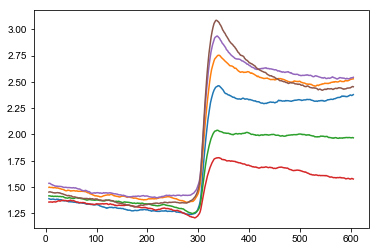

In [23]:
fig, ax = plt.subplots()

for sample, matrix in sense_data.items():
    if ('in' not in sample)  and 'rh' not in sample:
        ax.plot(matrix.loc[(matrix.mean(axis=1) > 0.01) & 
                           (matrix.mean(axis=1) < 10), :].mean(axis=0),
                label = sample)

# Chymograph plot with Groseq expression

In [25]:
groseq_rpkm = pd.read_hdf('/Volumes/Pegasus/shared_files/bed_files/hg38/HeLa_expression/rpkm_values_groseq.hdf')

In [26]:
groseq_rpkm.head()

,chr,start,end,transcript,rep1_p,rep2_p,rep1_m,rep2_m,strand,mean_sense_reads
0,chr1,11868,14409,ENST00000456328.2,0.187619,0.082893,4.065069,1.707606,+,0.135256
1,chr1,14403,29570,ENST00000488147.1,0.628653,0.024998,1.823093,1.780383,-,1.801738
2,chr1,17368,17436,ENST00000619216.1,0.000000,0.000000,7.010865,12.390139,-,9.700502
3,chr1,29553,31097,ENST00000473358.1,3.293532,0.109136,0.205846,0.109136,+,1.701334
4,chr1,30365,30503,ENST00000607096.1,0.000000,0.000000,0.000000,0.000000,+,0.000000


In [27]:
used_genes = used_genes.merge(groseq_rpkm[['transcript', 'mean_sense_reads']], left_on='gencode', right_on='transcript', how='left')

In [32]:
mean_ip_data = (sense_data['gl3_2']/million_mapped['gl3_2'] + 
                sense_data['gl3_3']/million_mapped['gl3_3'])/2

Text(0.5,0,'Distance upstream of TSS')

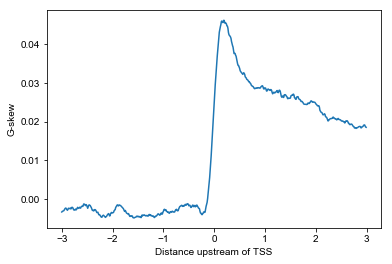

In [29]:
fig, ax = plt.subplots()
ax.plot(np.arange(-3, 3, 0.01), gc_skew.mean(axis=0))
ax.set_ylabel('G-skew')
ax.set_xlabel('Distance upstream of TSS')

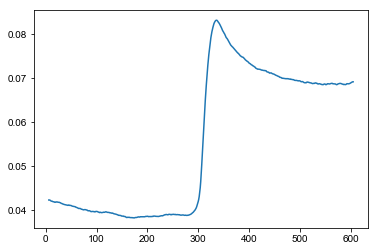

In [30]:
fig, ax = plt.subplots()
plt.plot(mean_ip_data[mean_ip_data.mean(axis = 1) < np.percentile(mean_ip_data.mean(axis=1), 90)].mean(axis=0))

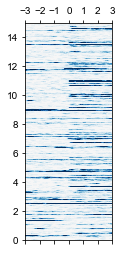

In [31]:
fig,ax = plt.subplots(figsize = (2, 4))

ax.matshow(mean_ip_data.iloc[np.argsort(gc_skew.iloc[:, 300:350].mean(axis=1))[::-1], :], 
           cmap='RdBu', vmin=-0.5, vmax=0.5, extent = [-3,3, 0 ,15]
           )

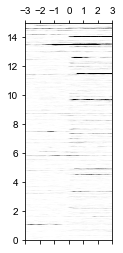

In [31]:
fig,ax = plt.subplots(figsize = (2, 4))

ax.matshow(mean_ip_data.iloc[np.argsort(gc_skew.mean(axis=1))[::-1], :], 
           cmap='Greys', vmin=0, vmax=2, extent = [-3,3, 0 ,15]
           )

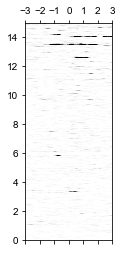

In [32]:
fig,ax = plt.subplots(figsize = (2, 4))

ax.matshow(sense_data['gl3_rh'].iloc[np.argsort(gc_skew.mean(axis=1))[::-1], :] /million_mapped['gl3_rh'], 
           cmap='Greys', vmin=0, vmax=2, extent = [-3,3, 0 ,15]
           )

In [33]:
rh_to_ip_ratio = np.log2((sense_data['gl3_rh'].mean(axis=1)/million_mapped['gl3_rh'])/mean_ip_data.mean(axis=1))

/Users/cimprich/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.


In [34]:
len(sense_data['gl3_rh'].loc[mask, :])

NameError: name 'mask' is not defined

Text(0,0.5,'Mean IP +RNaseH signal (RPKM)')

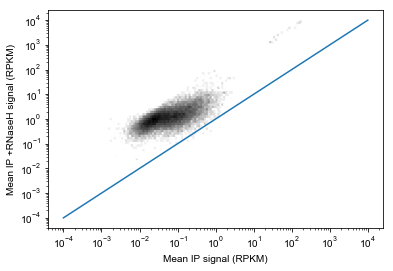

In [36]:
fig,ax=plt.subplots()

mask = ((mean_ip_data.iloc[:, 300:350].mean(axis=1) > 0) & (sense_data['gl3_rh'].iloc[:, 300:350].mean(axis=1) > 0)).as_matrix()

ax.hexbin(mean_ip_data.loc[mask,:].iloc[:, :].mean(axis=1), 
           sense_data['gl3_rh'].loc[mask, :].iloc[:, :].mean(axis=1),
           xscale = 'log', yscale='log', cmap='Greys', bins='log'
           )
ax.plot([1e-4, 1e4], [1e-4,1e4])
ax.set_xlabel('Mean IP signal (RPKM)')
ax.set_ylabel('Mean IP +RNaseH signal (RPKM)')

Text(0,0.5,'Mean IP +RNaseH signal (RPKM)')

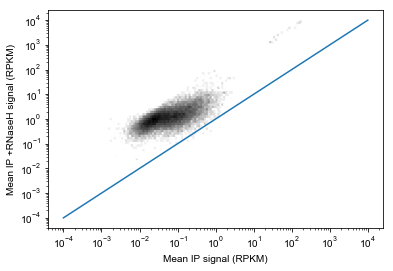

In [37]:
fig,ax=plt.subplots()

mask = ((mean_ip_data.iloc[:, 300:350].mean(axis=1) > 0) & (sense_data['gl3_rh'].iloc[:, 300:350].mean(axis=1) > 0)).as_matrix()

ax.hexbin(mean_ip_data.loc[mask,:].iloc[:, :].mean(axis=1), 
           sense_data['gl3_rh'].loc[mask, :].iloc[:, :].mean(axis=1),
           xscale = 'log', yscale='log', cmap='Greys', bins='log'
           )
ax.plot([1e-4, 1e4], [1e-4,1e4])
ax.set_xlabel('Mean IP signal (RPKM)')
ax.set_ylabel('Mean IP +RNaseH signal (RPKM)')

In [38]:
rh_high_in_gene = ((sense_data['gl3_rh'].iloc[:, 300:]).mean(axis=1) > (1.5 * sense_data['gl3_rh'].iloc[:, :300]).mean(axis=1))

In [39]:
drip_high_in_gene = ((mean_ip_data.iloc[:, 300:]).mean(axis=1) > (1.5 * mean_ip_data.iloc[:, :300]).mean(axis=1))

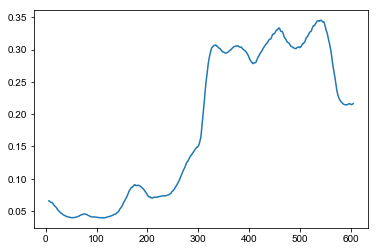

In [40]:
plt.plot(mean_ip_data[drip_high_in_gene].mean(axis=0))

In [41]:
def order_by_matrix(out_mat, order_mat = None, agg_func = functools.partial(np.mean, axis=1), top_n = None):
    if top_n is None:
        top_n = len(out_mat)
    if type(out_mat) == pd.DataFrame:
        out_mat = out_mat.as_matrix()
    if order_mat is None:
        order_mat = out_mat
    return out_mat[np.argsort(agg_func(order_mat))[::-1][0:top_n], :]

def nice_matplot(mat, ax, **matshow_kwargs):
    if 'vmin' not in matshow_kwargs:
        matshow_kwargs['vmin'] = 0
    if 'vmax' not in matshow_kwargs:
        matshow_kwargs['vmax'] = 2
    if 'extent' not in matshow_kwargs:
        matshow_kwargs['extent'] = [-3,3,0,15]
    if 'cmap' not in matshow_kwargs:
        matshow_kwargs['cmap'] = 'Greys' 
    ax.matshow(mat, **matshow_kwargs)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)

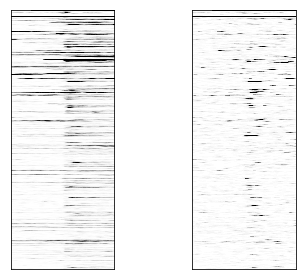

In [42]:
fig, ax = plt.subplots(ncols = 2)

def no_op(x):
    return x

order_matrix = used_genes.mean_sense_reads

nice_matplot(order_by_matrix(mean_ip_data, order_matrix , agg_func=no_op, top_n=5000), ax=ax[0], vmax=2)
nice_matplot(order_by_matrix(sense_data['gl3_rh'] / million_mapped['gl3_rh'], order_matrix,agg_func=no_op, top_n=5000), ax=ax[1], vmax=2)
fig.tight_layout()

NameError: name 'order_by_matrix' is not defined

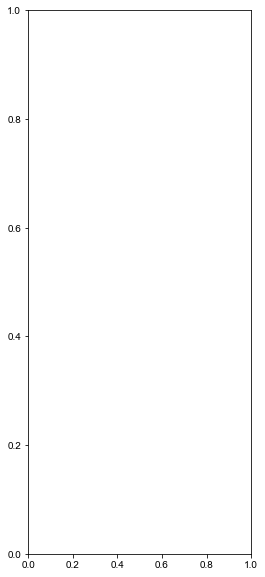

In [34]:
fig, ax = plt.subplots(figsize=(4,10))
expr_genes = order_by_matrix(mean_ip_data, order_matrix , agg_func=no_op, top_n = 10335)[335:, :]
expr_rh = order_by_matrix(sense_data['gl3_rh'] / million_mapped['gl3_rh'], order_matrix , agg_func=no_op, top_n = 10355)[335:, :]
expr_in = order_by_matrix(sense_data['gl3_in']/ million_mapped['gl3_in'], order_matrix , agg_func=no_op, top_n = 10355)[335:, :]
nice_matplot(expr_genes, ax=ax, vmax=2)

In [44]:
len(mean_ip_data), len(order_matrix)

(33576, 33576)

/Users/cimprich/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


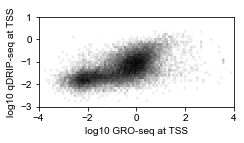

In [40]:
fig, ax = plt.subplots(figsize=(3.5,2))
x,y = np.log10(used_genes.mean_sense_reads), np.log10(mean_ip_data.mean(axis=1))
mask = np.isfinite(x.as_matrix()) & np.isfinite(y.as_matrix())
ax.hexbin(x[mask], y[mask], bins='log', cmap='Greys')
#ax.plot([-4,4], [1.0659 + 1.2956 * -4, 1.0659 + 1.2956 * 4])
ax.set_xlim(-4,4)
ax.set_ylim(-3,1)
ax.set_ylabel('log10 qDRIP-seq at TSS')
ax.set_xlabel('log10 GRO-seq at TSS')
fig.tight_layout()
fig.savefig('txn_correl.svg')

/Users/cimprich/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


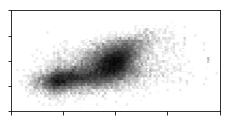

In [41]:
fig, ax = plt.subplots(figsize=(3.3,1.8))
x,y = np.log10(used_genes.mean_sense_reads), np.log10(mean_ip_data.mean(axis=1))
mask = np.isfinite(x.as_matrix()) & np.isfinite(y.as_matrix())
ax.hexbin(x[mask], y[mask], bins='log', cmap='Greys')
#ax.plot([-4,4], [1.0659 + 1.2956 * -4, 1.0659 + 1.2956 * 4])
ax.set_xlim(-4,4)
ax.set_ylim(-3,1)
for t in ax.get_xticklabels():
    t.set_visible(False)
for t in ax.get_yticklabels():
    t.set_visible(False)
ax.set_ylabel('')
ax.set_xlabel('')
fig.tight_layout()
fig.savefig('txn_correl_no_label.svg')

In [104]:
!pwd

/Volumes/Pegasus/DRIP_spike_in/qdrip/notebooks/metaplots


In [52]:
len(y)

33576

In [42]:
mask = np.array(np.isfinite(x)) & np.array(np.isfinite(y)) 

In [43]:
mask.sum()

31589

In [97]:
data = pd.DataFrame({'endog': y[mask].as_matrix(), 'exog': x[mask].as_matrix()})
endog = sm.add_constant(data.endog)
m = sm.OLS(data.exog, endog)

In [98]:
res = m.fit()

In [99]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   exog   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                 1.955e+04
Date:                Tue, 24 Sep 2019   Prob (F-statistic):               0.00
Time:                        17:40:54   Log-Likelihood:                -38654.
No. Observations:               31589   AIC:                         7.731e+04
Df Residuals:                   31587   BIC:                         7.733e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0659      0.013     82.592      0.000       1.041       1.091
endog          1.2956      0.009    139.829      0.000       1.277       1.314
==============================================================================
Omnibus:                     1232.475   Durbin-Watson:                   1.339
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2424.188
Skew:                           0.290   Prob(JB):                         0.00
Kurtosis:                       4.227   Cond. No.                         5.71
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [86]:
np.corrcoef(x[mask], y[mask]) ** 2

array([[1.        , 0.16345367],
       [0.16345367, 1.        ]])

In [47]:
stats.pearsonr(x[mask], y[mask])

(0.6183311052397289, 0.0)

In [59]:
stats.spearmanr(x[mask], y[mask])

SpearmanrResult(correlation=0.6356433777992313, pvalue=0.0)

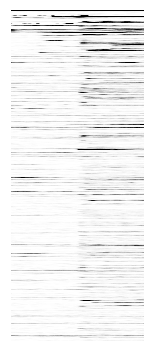

In [48]:
fig, ax = plt.subplots(figsize=(3.5,5))
nice_matplot(order_by_matrix(mean_ip_data, order_matrix , agg_func=no_op, top_n = 10000), ax=ax, vmax=2)
fig.tight_layout()
ax.axis('off') # Remove frame around plot
fig.savefig('top_10000_R-loops_gene_expression.png', dpi=300)
fig.savefig('top_10000_R-loops_gene_expression.pdf')

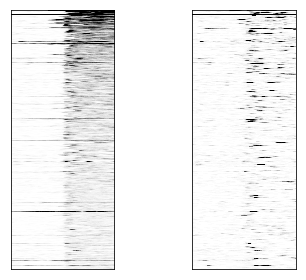

In [49]:
fig, ax = plt.subplots(ncols = 2)

order_matrix = mean_ip_data.iloc[:, 300:].as_matrix() - mean_ip_data.iloc[:, :300].as_matrix()

nice_matplot(order_by_matrix(mean_ip_data, order_matrix , top_n=4000), ax=ax[0], vmax=2)
nice_matplot(order_by_matrix(sense_data['gl3_rh'] / million_mapped['gl3_rh'], order_matrix, top_n=4000), ax=ax[1], vmax=2)
fig.tight_layout()

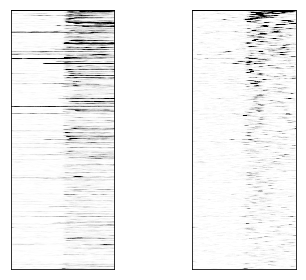

In [50]:
fig, ax = plt.subplots(ncols = 2)

order_matrix = sense_data['gl3_rh'].iloc[:, 300:].as_matrix() - sense_data['gl3_rh'].iloc[:, :300].as_matrix()

nice_matplot(order_by_matrix(mean_ip_data, order_matrix , top_n=4000), ax=ax[0], vmax=2)
nice_matplot(order_by_matrix(sense_data['gl3_rh'] / million_mapped['gl3_rh'], order_matrix, top_n=4000), ax=ax[1], vmax=2)
fig.tight_layout()

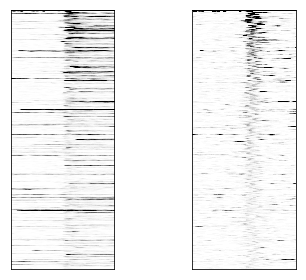

In [51]:
fig, ax = plt.subplots(ncols = 2)

order_matrix = sense_data['gl3_rh'].iloc[:, 300:400]

nice_matplot(order_by_matrix(mean_ip_data, order_matrix , top_n=4000), ax=ax[0], vmax=2)
nice_matplot(order_by_matrix(sense_data['gl3_rh'] / million_mapped['gl3_rh'], order_matrix, top_n=4000), ax=ax[1], vmax=2)
fig.tight_layout()

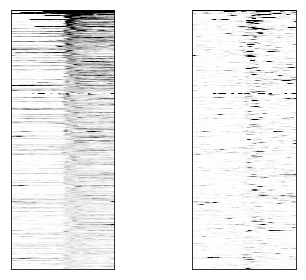

In [52]:
fig, ax = plt.subplots(ncols = 2)

order_matrix = mean_ip_data.iloc[:, 300:400]

nice_matplot(order_by_matrix(mean_ip_data, order_matrix , top_n=4000), ax=ax[0], vmax=2)
nice_matplot(order_by_matrix(sense_data['gl3_rh'] / million_mapped['gl3_rh'], order_matrix, top_n=4000), ax=ax[1], vmax=2)
fig.tight_layout()

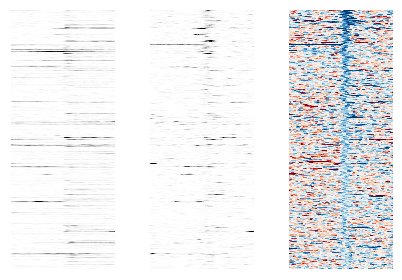

In [53]:
fig, ax = plt.subplots(ncols = 3)

order_matrix = gc_skew.iloc[:, 300:350]

nice_matplot(order_by_matrix(mean_ip_data, order_matrix , top_n=10000), ax=ax[0], vmax=2)
nice_matplot(order_by_matrix(sense_data['gl3_rh'] / million_mapped['gl3_rh'], order_matrix, top_n=10000), ax=ax[1], vmax=2)
nice_matplot(order_by_matrix(gc_skew, order_matrix, top_n=10000), ax=ax[2], vmax=0.5, vmin=-0.5, cmap='RdBu')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
fig.tight_layout()
fig.savefig('ip_and_rh_and_skew.png', dpi=400)

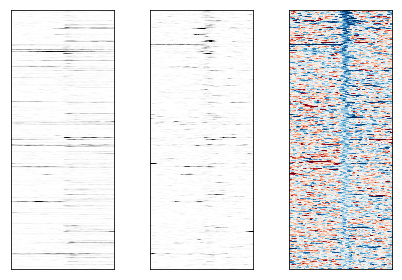

In [54]:
fig, ax = plt.subplots(ncols = 3)

order_matrix = gc_skew.iloc[:, 300:350]

nice_matplot(order_by_matrix(mean_ip_data, order_matrix , top_n=10000), ax=ax[0], vmax=2)
nice_matplot(order_by_matrix(sense_data['gl3_rh'] / million_mapped['gl3_rh'], order_matrix, top_n=10000), ax=ax[1], vmax=2)
nice_matplot(order_by_matrix(gc_skew, order_matrix, top_n=10000), ax=ax[2], vmax=0.5, vmin=-0.5, cmap='RdBu')
fig.tight_layout()
fig.savefig('ip_and_rh_and_skew.png', dpi=400)

In [55]:
?mpl.cm.ScalarMappable

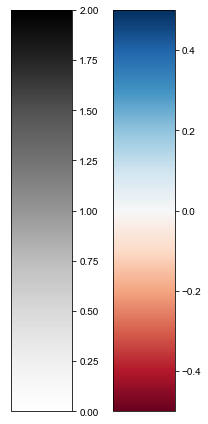

In [56]:
fig, ax = plt.subplots(figsize=(3, 6), ncols=2)
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.Greys
norm = mpl.colors.Normalize(vmin=0, vmax=2)
norm_2 = mpl.colors.Normalize(vmin = -0.5, vmax=0.5)

cb1 = mpl.colorbar.ColorbarBase(ax[0], cmap=cmap,
                                norm=norm,
                                )

cb2 = mpl.colorbar.ColorbarBase(ax[1], cmap=mpl.cm.RdBu,
                                norm=norm_2,
                                )
fig.tight_layout()
fig.savefig('colorbars.svg')

In [57]:
fig, ax = plt.subplots(ncols = 2, figsize = (7.5, 1.5), sharey=True)

sns.barplot(ax = ax[0], # Left plot
            data = df.loc[df.probe_name.isin(['ACTB', 'MYC']), :] # Replace gene names as necessary
            x = 'probe_name',
           )
sns.barplot(ax = ax[1], # Left plot
            data = df.loc[df.probe_name.isin(['ACTB', 'MYC']), :] # Replace gene names as necessary
            x = 'probe_name',
           )

long_string = ('This is text on line1'
               ' and this is more text but it\'s also on line 1'
              )

"""
ax[0].set_ylabel('')
ax[1].set_ylabel('')
"""

"""
for a in ax:
    a.set_ylabel(‘’)
    a.set_yticklabels('')
"""

fig.savefig()

SyntaxError: invalid syntax (<ipython-input-57-624c161e51f9>, line 5)

In [ ]:
fig,ax = plt.subplots(figsize = (2, 4))

tick_loc = mpl.ticker.MultipleLocator(base=3.0)

ax.matshow(sense_data['gl3_rh'].iloc[np.argsort(used_genes.mean_sense_reads)[::-1], :] / million_mapped['gl3_rh'],
           extent = [-3, 3, 0, 15],
           cmap = 'Greys',
           vmin = 0, vmax = 1
          )
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

In [86]:
def bootstrap_samples(mat, n_samples, agg_func = np.mean, verbose=False, sample_name = ''):
    agg_func = functools.partial(agg_func, axis=0)
    boot_samples = np.empty((n_samples, mat.shape[1]), dtype=np.float32)
    for i in range(n_samples):
        if verbose and not i % (n_samples // 25):
            print(sample_name, (i / n_samples) * 100)
        boot_samples[i, :] = agg_func(mat[np.random.choice(len(mat), len(mat), replace=True), :])
    return boot_samples

In [87]:
def mean_95_ci(ax, mat, color='blue'):
    ax.plot(np.arange(-3, 3, 0.01), mat.mean(axis=0), color=color)
    ax.fill_between(np.arange(-3, 3, 0.01), 
                    np.percentile(mat, 2.5, axis=0), 
                    np.percentile(mat, 97.5, axis=0),
                    alpha = 0.5, color=color)

In [88]:
len(sense_data['gl3_rh'])

33576

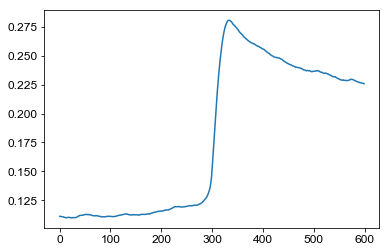

In [89]:
plt.plot(expr_genes.mean(axis=0))

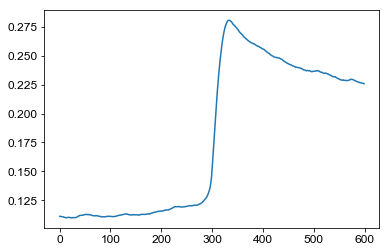

In [90]:
plt.plot(expr_genes.mean(axis=0))

In [92]:
type(expr_genes)

numpy.ndarray

In [91]:
bootstrapped = {}
bootstrapped['IP'] = bootstrap_samples(expr_genes, 10000, verbose=True, sample_name='IP')
bootstrapped['RH'] = bootstrap_samples(expr_rh, 10000, verbose=True, sample_name='RH')
bootstrapped['IN'] = bootstrap_samples(expr_in, 10000, verbose=True, sample_name='Input')

IP 0.0
IP 4.0
IP 8.0
IP 12.0
IP 16.0
IP 20.0
IP 24.0
IP 28.000000000000004
IP 32.0
IP 36.0
IP 40.0
IP 44.0
IP 48.0
IP 52.0
IP 56.00000000000001
IP 60.0
IP 64.0
IP 68.0
IP 72.0
IP 76.0
IP 80.0
IP 84.0
IP 88.0
IP 92.0
IP 96.0
RH 0.0
RH 4.0
RH 8.0
RH 12.0
RH 16.0
RH 20.0
RH 24.0
RH 28.000000000000004
RH 32.0
RH 36.0
RH 40.0
RH 44.0
RH 48.0
RH 52.0
RH 56.00000000000001
RH 60.0
RH 64.0
RH 68.0
RH 72.0
RH 76.0
RH 80.0
RH 84.0
RH 88.0
RH 92.0
RH 96.0
Input 0.0
Input 4.0
Input 8.0
Input 12.0
Input 16.0
Input 20.0
Input 24.0
Input 28.000000000000004
Input 32.0
Input 36.0
Input 40.0
Input 44.0
Input 48.0
Input 52.0
Input 56.00000000000001
Input 60.0
Input 64.0
Input 68.0
Input 72.0
Input 76.0
Input 80.0
Input 84.0
Input 88.0
Input 92.0
Input 96.0


In [ ]:
bootstrapped['g_skew'] = bootstrap_samples(gc_skew.as_matrix(), 1000, verbose=True)

In [ ]:
fig, ax = plt.subplots(nrows = 2, figsize=(5,5), sharex=True)

mean_95_ci(ax[0], bootstrapped['g_skew'], color=down_color)
mean_95_ci(ax[1], bootstrapped['IP'], color=down_color)
mean_95_ci(ax[1], bootstrapped['RH'] , color=up_color)
mean_95_ci(ax[1], bootstrapped['IN'], color='#444444')

handles = [
    mpl.patches.Patch(color = down_color, alpha = 0.5),
    mpl.patches.Patch(color = up_color, alpha = 0.5),
    mpl.patches.Patch(color = '#444444', alpha = 0.5),
]
labels = ['Mean IP', 'IP +RH', 'Input']
ax[1].legend(handles,labels, frameon=False)

ax[0].set_ylabel('GC-skew')
ax[1].set_ylabel('qDRIP IP signal')
ax[1].set_xlabel('Distance upstream of TSS')

fig.savefig('GC_skew_vs_R-loops.svg')

(0.026158762583509087, 0.3012529868166894)

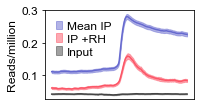

In [94]:
fig, ax = plt.subplots(figsize=(3,1.7))

up_color, down_color =  '#fc5566', '#6669cf'

mean_95_ci(ax, bootstrapped['IP'], color=down_color)
mean_95_ci(ax, bootstrapped['RH'], color=up_color)
mean_95_ci(ax, bootstrapped['IN'], color='#444444')
ax.xaxis.set_visible(False)
ax.set_ylabel('Reads/million')

handles = [
    mpl.patches.Patch(color = down_color, alpha = 0.5),
    mpl.patches.Patch(color = up_color, alpha = 0.5),
    mpl.patches.Patch(color = '#444444', alpha = 0.5),
]
labels = ['Mean IP', 'IP +RH', 'Input']
ax.legend(handles,labels, frameon=False, labelspacing=0.2, handlelength=0.5, handletextpad=0.4, )
fig.tight_layout()
ax.get_ylim()
#fig.savefig('Mean_IP_all_categories.pdf', transparent=True)
#fig.savefig('Mean_IP_all_categories.svg', transparent=True)

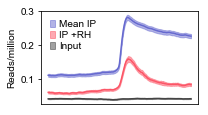

In [53]:
fig, ax = plt.subplots(figsize=(3,1.7))

up_color, down_color =  '#fc5566', '#6669cf'

mean_95_ci(ax, bootstrapped['IP'], color=down_color)
mean_95_ci(ax, bootstrapped['RH'], color=up_color)
mean_95_ci(ax, bootstrapped['IN'], color='#444444')
ax.xaxis.set_visible(False)
ax.set_ylabel('Reads/million')

handles = [
    mpl.patches.Patch(color = down_color, alpha = 0.5),
    mpl.patches.Patch(color = up_color, alpha = 0.5),
    mpl.patches.Patch(color = '#444444', alpha = 0.5),
]
labels = ['Mean IP', 'IP +RH', 'Input']
ax.legend(handles,labels, frameon=False, labelspacing=0.2, handlelength=0.5, handletextpad=0.4, )
fig.tight_layout()
fig.savefig('Mean_IP_all_categories.pdf', transparent=True)
fig.savefig('Mean_IP_all_categories.svg', transparent=True)

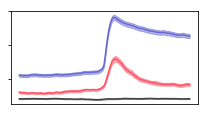

In [56]:
fig, ax = plt.subplots(figsize=(3,1.7))

up_color, down_color =  '#fc5566', '#6669cf'

mean_95_ci(ax, bootstrapped['IP'], color=down_color)
mean_95_ci(ax, bootstrapped['RH'], color=up_color)
mean_95_ci(ax, bootstrapped['IN'], color='#444444')
ax.xaxis.set_visible(False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_yticklabels('')

fig.tight_layout()
fig.savefig('Mean_IP_all_categories.pdf', transparent=True)
fig.savefig('Mean_IP_all_categories.svg', transparent=True)

In [105]:
?ax.legend